In [1]:

## Gerekli kütüphaneler
import pandas as pd
from urllib.parse import urlparse
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

from dtaidistance import dtw
from scipy.cluster.hierarchy import dendrogram, linkage

from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

In [2]:

# Log'larda karşılaştığımız dosya tiplerini birer feature haline çevireceğiz
# Bu listede olmayan tipleri other olarak işaretleyeceğiz

ext_list = ['php', 'webp', 'ico', 'jpg', 'jpeg', 'png', 'js', 'gif', 'css', 'woff2', 'woff',
 'json','ashx','xml','html','asp','txt','svg','pdf','zip','ttf',
 'eot','map','bmp'];
#ext_list = ['php']

In [3]:
############ VERİ ÖNİŞLEME FONKSİYON TANIMLARI #################

### İstek url'sinin tipini belirleyen fonksiyon
def get_extension(url):
    if not isinstance(url, str):
#        print(url)
        return 'other'
    
    parsed_url = urlparse(url)
    # Path'i al
    path = parsed_url.path
    # Path'in sonundaki dosya adını ve uzantısını al
    if '.' in path.split('/')[-1]:
        ext = path.split('/')[-1].split('.')[-1]
    else:  # Sistem tasarımından dolayı uzantı yoksa isteği karşılayan dosya php dosyasıdır
        ext = 'php'
        
    ext = ext.lower();
    if(ext=='jpeg'):
        ext = 'jpg'
    if ext in ext_list:
        return ext;
    return 'other';

In [4]:

# Querystring parçalama
# Querystring bir url sonunda ? karakterinden sonra gelen veridir. 
# İstemci bir web formundan GET metoduyla sunucuya veri iletir. Bu veri adres satırında görülür.
# Dosya tiplerini düzgün alabilmek için querystringi ayırmamız lazım

def split_qs(df,col,new_col1,new_col2):
    split_df = df[col].str.split('?', n=1, expand=True)
    if split_df.shape[1] == 1:
    # İkinci sütun yoksa, boş bir sütun ekle
        split_df[1] = ''
    
# Eğer '?' işareti yoksa ve yalnızca bir kolon dönüyorsa, uyumluluk için ikinci kolonu boş stringle doldur
    split_df[1] = split_df[1].fillna('')

    df[[new_col1, new_col2]] = split_df

    return df


In [5]:

# Veri önişleme yapan fonksiyon
# Logdaki request'ten bazı verileri temizliyoruz
# Querystring'i temizleyip get_extension fonksiyonu ile istek url'sindeki dosya tipini belirliyoruz
def prepare_data(df):
    
    df = df.dropna(subset=['request'])
    
    df['request'] = df['request'].str.replace(' HTTP/1.1','')

    df = split_qs(df, 'request', 'url', 'query_string')

    df[['request_type', 'url']] = df['url'].str.split(' ', n=1, expand=True)


    df['http_referer'] = df['http_referer'].str.replace('http://','')
    df['http_referer'] = df['http_referer'].str.replace('https://','')
# Uzantıları yeni bir sütuna ekleyelim
    df['file_type'] = df['url'].apply(get_extension)
#    df['impressions_flag'] = df['url'].apply(lambda x: 1 if 'impressions.php' in x else 0)


    df = split_qs(df, 'http_referer', 'referer_domain', 'referer_query_string')

    
    df.drop(['time_local','body_bytes_sent','request_time','http_x_forwarded_for','request',
      #   'referer_domain'
         'referer_query_string','http_referer'],
        axis=1,inplace=True)

    df.drop(['http_user_agent','url','query_string','referer_domain'],
        axis=1,inplace=True)

    return df

In [6]:

# İstek yapılan dosya tipini OneHot Encoding ile sütunlara yerleştiriyoruz
def prepare_file_type(df):
    enc1 = OneHotEncoder()
    encoded_data1 = enc1.fit_transform(df[['status']])

    enc2 = OneHotEncoder()
    encoded_data2 = enc2.fit_transform(df[['file_type']])

    enc3 = OneHotEncoder()
    encoded_data3 = enc3.fit_transform(df[['request_type']])

    df_encoded = pd.DataFrame(encoded_data1.toarray(), columns=enc1.get_feature_names_out(['status']))
    df = pd.concat([df, df_encoded], axis=1)

    df_encoded = pd.DataFrame(encoded_data2.toarray(), columns=enc2.get_feature_names_out(['file_type']))
    df = pd.concat([df, df_encoded], axis=1)

    df_encoded = pd.DataFrame(encoded_data3.toarray(), columns=enc3.get_feature_names_out(['request_type']))
    df = pd.concat([df, df_encoded], axis=1)

    df.drop(['status','file_type','request_type'],axis=1,inplace=True);
    # df = df.join(df,X)
    
    
    return df

In [7]:

# IP bazında Her bir istek bir öncekinden kaç saniye sonra gelmiş.
# İlk isteğin zaman damgasını 0 yapıp her istek arasındaki zaman farkını hesaplıyoruz.
# msec ile belirtilen alan aslında saniye cinsinden unix epoch zaman damgasıdır.
# Sunucu loglarında msec diye kaydedildiği için bu ismi aynı kullandım. Aslında milisaniye değil, saniye

def set_time_diff(df):
   n = {}
   i = 0
   for row in df['remote_addr'].unique():
       secim = df[df['remote_addr'] == row]

       # 10 hareketten az verileri almıyoruz.
       # Bunların log başlangıcı veya sonunda yarım kalmış hareket olduğunu varsayıyoruz
       if len(secim) < 10:
           continue
       
       secim.sort_values('msec', ascending=True, inplace=True)
       
       #first_msec = secim['msec'].iloc[0]
       #secim['msec_diff'] = secim['msec'] - first_msec
       
       secim['msec_diff'] = secim['msec'].diff()
       #### php dosyaları arasındaki zaman farklarını hesaplayalım
       php_df = secim[secim['file_type_php'] == 1].copy()
       
       php_df['msec_diff_php'] = php_df['msec'].diff()
       
       secim['msec_diff_php'] = 0.0;
       
       secim.loc[php_df.index, 'msec_diff_php'] = php_df['msec_diff_php']
       ###################
       
       secim.fillna(0, inplace=True)
       # Drop the original 'msec' column and sort by 'msec_diff'
       secim.drop(['msec'], axis=1, inplace=True)


##########  600 sn.(10 dk.) içindeki hareketleri tek bir davranış olarak alıyoruz.
       threshold = 600
       threshold_indices = secim[ secim['msec_diff'] > threshold ].index
       if not threshold_indices.empty:
    # Eşik değerini aşan ilk satırın indeksini kullanarak DataFrame'i kırpma
           threshold_index = threshold_indices[0]
           secim = secim[:threshold_index]
##############################################################3

       # Store the processed DataFrame
       n[i] = secim
       i += 1
      # if(i>1000):
      #     break

   return n


In [8]:

### IP bazında msec_diff ortalama değerlerini alıyoruz.
### Ayrıca php dosyasına yapılan zaman damgalarını da php istek sayısına bölerek 
### 2 php isteği arasındaki ortalama zamanı hesaplıyoruz
def flatten_df(df_list):
    result_df = pd.DataFrame([])
   
    i=0
    for row in df_list:
        
        x = df_list[row].groupby('remote_addr').agg(
        {
         **{col: 'sum' for col in df_list[row].columns if col not in ['msec_diff']},
         'msec_diff': 'mean'
        }
        ).drop(['remote_addr'], axis=1).reset_index()

#### msec_diff yukarıdaki satırdan sonra mean değerine dönüştü, veri adını düzeltiyoruz
        x['time_mean'] = x['msec_diff']
#### msec_diff_php verisi yukarıda toplam olduğu için, file_type_php toplam sayısına bölüyoruz
        x['time_mean_php'] = x['msec_diff_php'] / x['file_type_php']
        
        x.drop(['msec_diff','msec_diff_php'],axis=1,inplace=True)
        
        result_df = pd.concat([result_df, x], axis=0, ignore_index=True)
        #result_df = pd.concat([result_df, y], axis=0, ignore_index=True)
#        if(i>10000):
#            return result_df
        i += 1
    
    return result_df

    

In [9]:
############ VERİ ÖNİŞLEME FONKSİYON TANIMLARI BİTTİ #################

In [11]:

pd.options.mode.copy_on_write = True

df = pd.read_csv('./nginx_1m.csv')
df_original = df.copy()

In [12]:

######## İşlenecek verileri ayrıştırıyor. Örneğin HTTP/1.1 gibi verileri siliyoruz
df = prepare_data(df)

######## Dosya tiplerine göre OneHotEncoding yapıyoruz
df = prepare_file_type(df)

####### Zaman farkları hesaplanıyor
n = set_time_diff(df)


##### Bu aşamada artık tüm IP'ler tek bir satıra alınmış oluyor
df_f = flatten_df(n.copy())


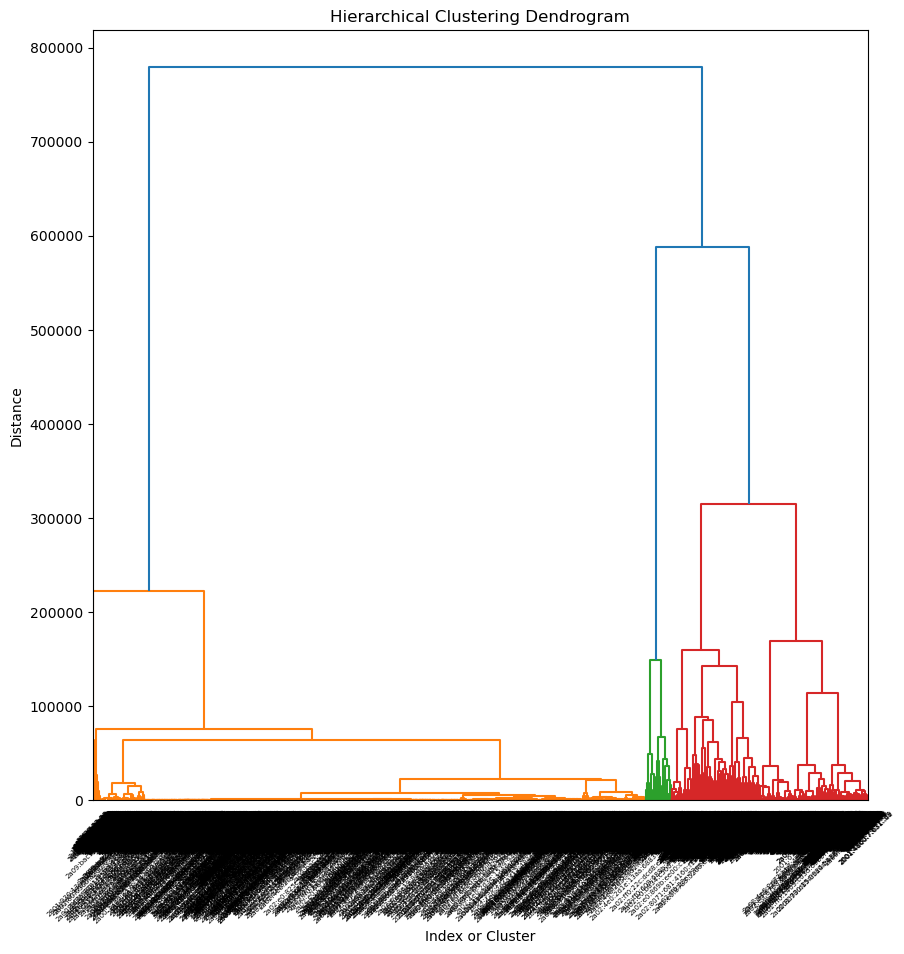

In [13]:

# Dynamic Time Warping algoritması için veri hazırlanıyor
time_series = [df2['msec_diff'].to_numpy() for df2 in n.values()]
addresses = [df2['remote_addr'].iloc[0] for df2 in n.values()]

# Dynamic Time Warping 
distances = dtw.distance_matrix_fast(time_series)


# 'distances' is your full square-form distance matrix
# Convert it to a condensed distance matrix
condensed_distances = squareform(distances, checks=False)

# Perform hierarchical clustering
Z = linkage(condensed_distances, 'ward')

# Time Series clustering için dendrogram hazırlama
plt.figure(figsize=(10, 10)) 


dendrogram(Z, labels=addresses, leaf_rotation=45)

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index or Cluster')
plt.ylabel('Distance')
plt.xticks(rotation=45)


plt.show()

In [14]:

# 4 küme için dendrogram
cluster_labels = fcluster(Z, t=4, criterion='maxclust')

# Create a DataFrame for easy analysis
clustered_data = pd.DataFrame({'Address': addresses, 'Cluster': cluster_labels})

clustered_data.sort_values('Cluster', ascending=True, inplace=True)


In [15]:

########### Elbow

n= df_f


### IP bazında kümeleri eşleştirmek için IP listesini r değişkeninde tutuyoruz
r = n['remote_addr']

n.drop(['remote_addr'],axis=1,inplace=True)

'''
n.drop(['status_200','status_200','status_206','status_301','status_302','status_304',
        'status_400','status_401','status_405','status_499','status_500',
        'status_404','status_403'],axis=1,inplace=True);
'''
n.drop(list(df.filter(regex='status_')), axis=1, inplace=True)

In [16]:

# Min-Max Scaler'ı başlatma
scaler = MinMaxScaler()

# DataFrame'i ölçeklendirme
scaled_data = scaler.fit_transform(n)

# Ölçeklendirilmiş verileri yeni bir DataFrame'e dönüştürme
n = pd.DataFrame(scaled_data, columns=n.columns)


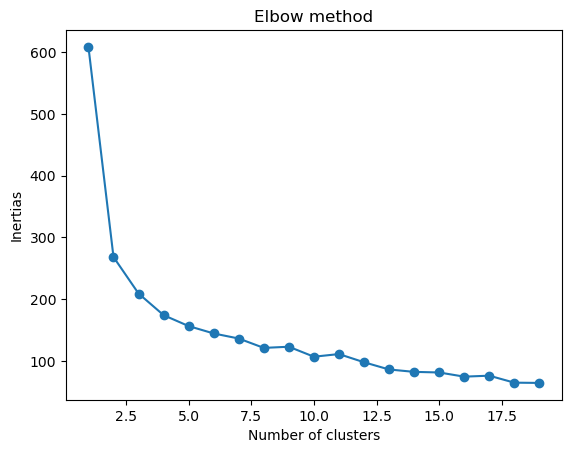

In [17]:

n.fillna(0, inplace=True)
 
inertias = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i,n_init='auto')
    kmeans.fit(n)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,20), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertias')
plt.show() 

##
labels = pd.DataFrame(kmeans.labels_)

kmeans = KMeans(n_clusters=4,n_init='auto').fit(n)

### IP listesini tekrar ekliyoruz
labels = pd.DataFrame(kmeans.labels_) 
n = pd.concat((n,r),axis=1)
labeled_n = pd.concat((n,labels),axis=1)
labeled_n = labeled_n.rename({0:'labels'},axis=1)

clusters = pd.concat((labeled_n['remote_addr'],labeled_n['labels']),axis=1, ignore_index=True)
clusters = clusters.sort_values(by=[1], ascending=True)